<a href="https://colab.research.google.com/github/dadaatom/Comp472_Project/blob/main/MaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PREPROCESSING IMPORTS #

import os
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms

In [3]:
# TRAINING IMPORTS #

import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [4]:
# EVALUATION IMPORTS #

import matplotlib.pyplot as plt
import itertools

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

================================ PREPROCESSING ================================

In [7]:
imagePath = "Dataset"
outputPath = "train_test_sets"

trainDir = outputPath+"/train"
testDir = outputPath+"/test"

classes = ["None", "N95", "Surgical", "Cloth"] #Folders should be labeled the same as these classes.

In [8]:
splitfolders.ratio(imagePath, output=outputPath, seed=0, ratio=(.8, 0.1,.1))

In [25]:
train_batch_size = 32
test_batch_size  = 100

img_height = 128
img_width = 128

In [26]:
transform = transforms.Compose([transforms.Resize((img_width, img_height)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_ds = datasets.ImageFolder(trainDir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=train_batch_size, shuffle=True)

test_ds = datasets.ImageFolder(testDir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=test_batch_size, shuffle=False)

================================ TRAINING ================================

In [46]:
num_epochs = 4
learning_rate = 0.0003

In [28]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layer = nn.Sequential(

        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(img_height * img_width * num_epochs, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    # conv layers
    x = self.conv_layer(x)

    # flatten
    x = x.view(x.size(0), -1)

    # fc layer
    x = self.fc_layer(x)

    return x

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN()
#model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [48]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
    #for (images, labels) in zip(imagesList, labelsList):
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss_list.append(loss.item())

      # Backprop and optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Train accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list.append(correct / total)

      if (i + 1) % 100 == 0:
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),(correct / total) * 100))

In [49]:
torch.save(model, "TrainedModel_V1")

In [15]:
# ======================= PREDICTIONS ======================= #

In [50]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for l,p in zip(labels.numpy(), predicted.numpy()):
            y_true.append(classes[l])
            y_pred.append(classes[p])

================================== EVALUATION ==================================

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
confusion_matrix(y_true=y_true, y_pred=y_pred)
cm_plot_labels = classes
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=cm_plot_labels)

Confusion matrix, without normalization
[[30  1  4 10]
 [ 9  2  4 14]
 [14  1 19  4]
 [11  4  6 22]]


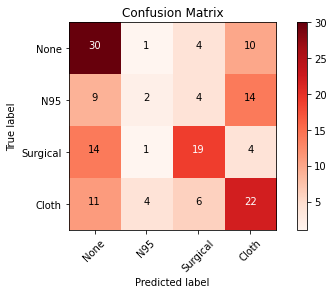

In [53]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix", cmap=plt.cm.Reds)

In [54]:
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred)

print(f"precision: {precision: .2f}")
print(f"recall: {recall: .2f}")
print(f"f1: {f1: .2f}")
print(f"accuracy: {accuracy: .2f}")

precision:  0.45
recall:  0.47
f1:  0.44
accuracy:  0.47
